In [1]:
import json
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer, default_data_collator
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import seaborn as sns
import numpy as np

In [2]:
# Lazy COCO-like Conversion Function
def convert_auair_to_detr_format_lazy(json_path, image_root):
    with open(json_path, "r") as f:
        auair_data = json.load(f)

    categories = auair_data["categories"]
    class_to_id = {name: idx for idx, name in enumerate(categories)}

    annotations = auair_data["annotations"]
    converted = []

    for image_id, ann in enumerate(annotations):
        file_name = ann["image_name"]
        width = int(ann["image_width:"])
        height = int(ann["image_height"])
        bboxes = ann["bbox"]

        bbox_list = []
        category_list = []
        area_list = []
        bbox_id_list = []

        for i, box in enumerate(bboxes):
            x_min = box["left"]
            y_min = box["top"]
            w = box["width"]
            h = box["height"]
            x_max = x_min + w
            y_max = y_min + h
            area = w * h

            bbox_list.append([x_min, y_min, x_max, y_max])
            category_list.append(box["class"])
            area_list.append(area)
            bbox_id_list.append(image_id * 1000 + i)

        converted.append({
            "image_id": image_id,
            "image_path": str(Path(image_root) / file_name),
            "width": width,
            "height": height,
            "objects": {
                "bbox_id": bbox_id_list,
                "category": category_list,
                "bbox": bbox_list,
                "area": area_list
            }
        })

    return converted

In [3]:
# Prepare Dataset and Processor
image_root = "data/images"
annotation_path = "data/annotations.json"
dataset_list = convert_auair_to_detr_format_lazy(annotation_path, image_root)

In [4]:
dataset_list[0]

{'image_id': 0,
 'image_path': 'data/images/frame_20190829091111_x_0001973.jpg',
 'width': 1920,
 'height': 1080,
 'objects': {'bbox_id': [0, 1, 2],
  'category': [1, 1, 0],
  'bbox': [[1098, 163, 1518, 348],
   [1128, 421, 1521, 597],
   [1703, 927, 1886, 1080]],
  'area': [77700, 69168, 27999]}}

In [5]:
# Split data
train_val, test = train_test_split(dataset_list, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [6]:
# Wrap as DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_list(train),
    "val": Dataset.from_list(val),
    "test": Dataset.from_list(test)
})

In [7]:
dataset["train"][0]

{'image_id': 27693,
 'image_path': 'data/images/frame_20190906150731_xx_0000129.jpg',
 'width': 1920,
 'height': 1080,
 'objects': {'area': [6732, 1550, 18128, 4002, 14536, 13760],
  'bbox': [[658, 665, 760, 731],
   [683, 636, 733, 667],
   [447, 665, 623, 768],
   [180, 595, 249, 653],
   [781, 638, 965, 717],
   [1364, 607, 1579, 671]],
  'bbox_id': [27693000, 27693001, 27693002, 27693003, 27693004, 27693005],
  'category': [5, 0, 1, 1, 1, 1]}}

In [8]:
train_data = dataset['train']
val_data = dataset['val']
test_data = dataset['test']

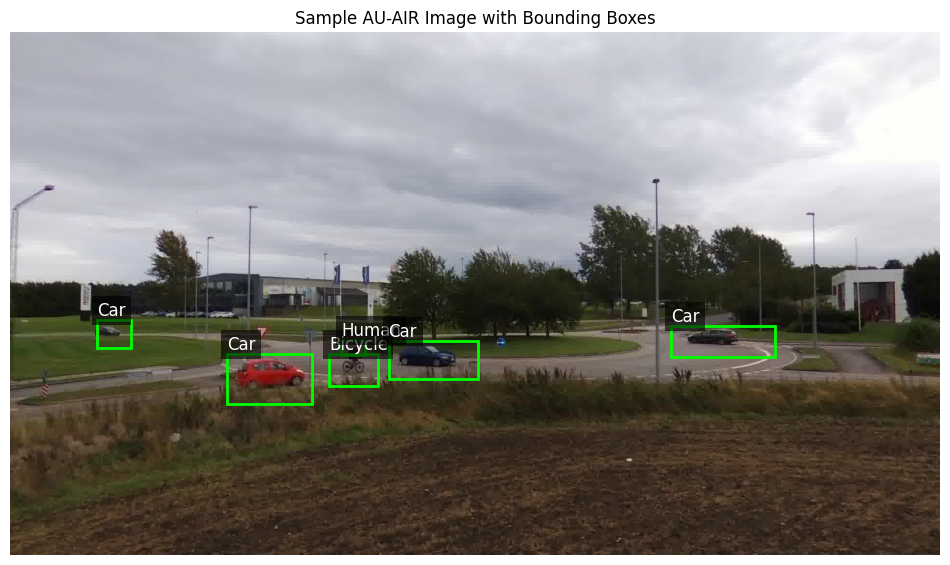

In [9]:
# Category mapping (hardcoded from your original AU-AIR structure)
categories = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]
id2label = {i: name for i, name in enumerate(categories)}

def visualize_auair_example(data_entry, id2label=id2label):
    image_path = data_entry["image_path"]
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for bbox, cat_id in zip(data_entry["objects"]["bbox"], data_entry["objects"]["category"]):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        label = id2label.get(cat_id, str(cat_id))

        # Draw rectangle
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor="lime", facecolor="none")
        ax.add_patch(rect)

        # Add label
        ax.text(x_min, y_min - 10, label, color="white", fontsize=12,
                bbox=dict(facecolor="black", alpha=0.6, edgecolor="none"))

    plt.title("Sample AU-AIR Image with Bounding Boxes")
    plt.axis("off")
    plt.show()

visualize_auair_example(train_data[0])

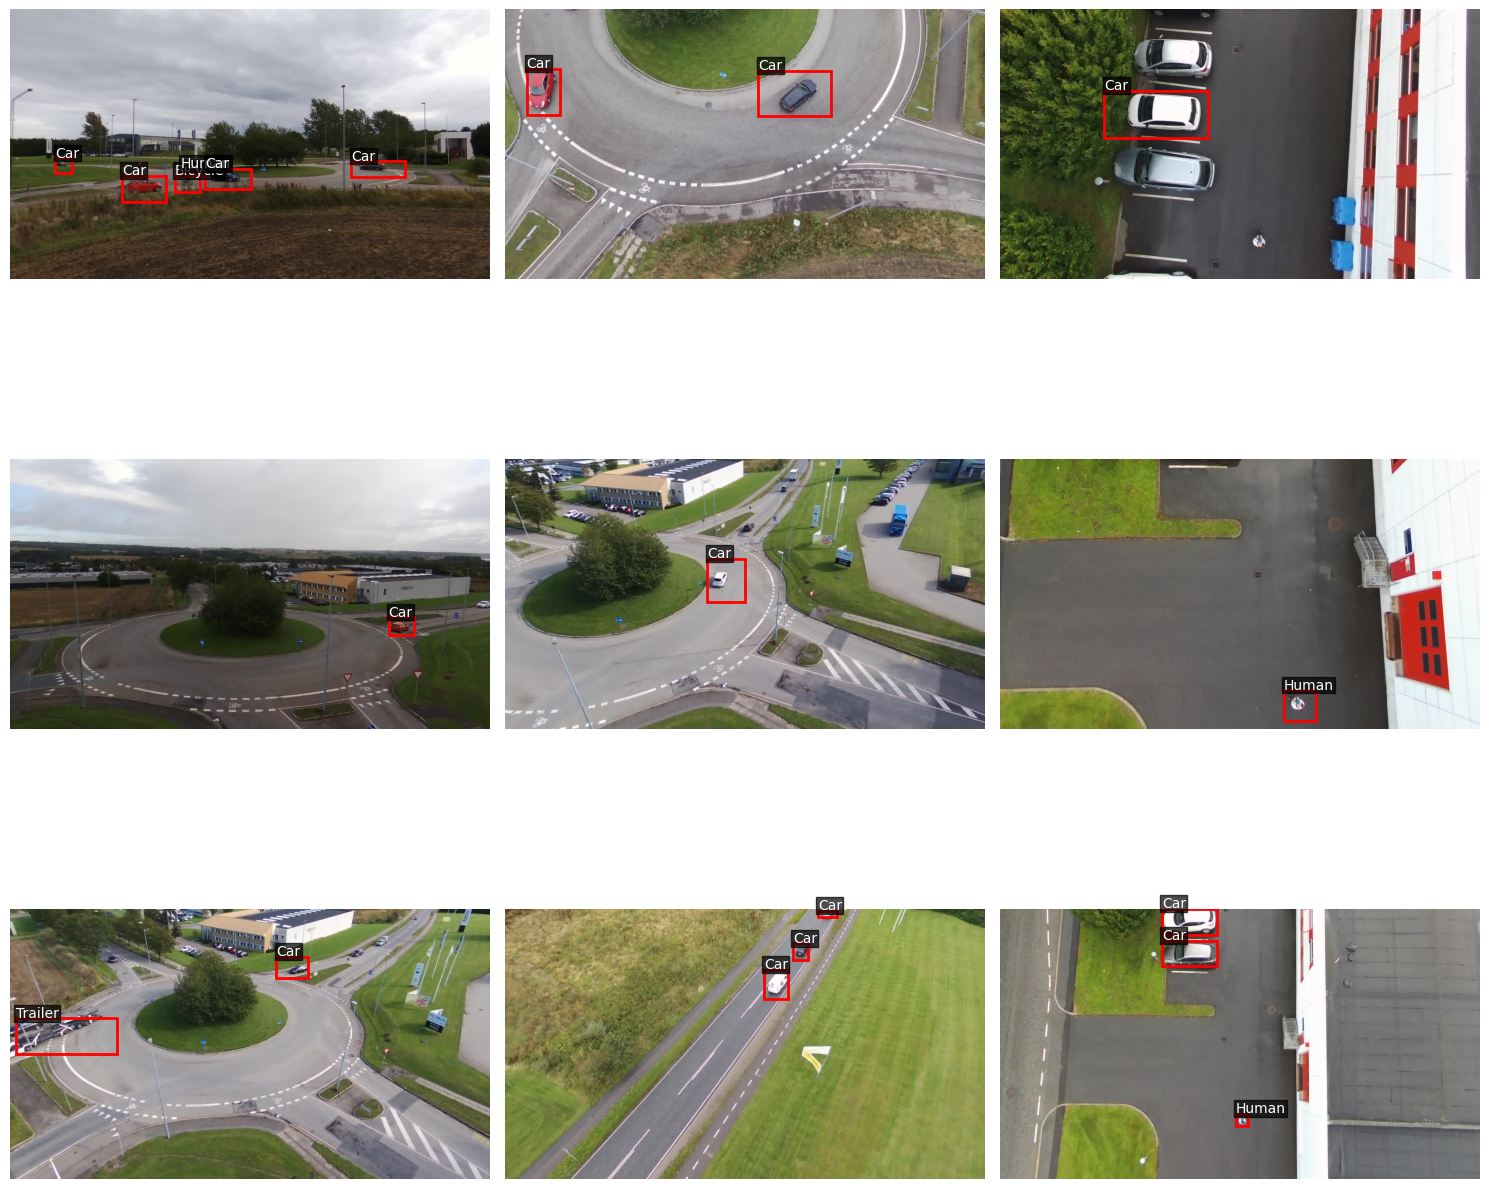

In [10]:
def plot_images(dataset, indices, id2label=id2label, cols=3):
    rows = (len(indices) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    if rows == 1:
        axs = [axs]  # single row edge case
    axs = axs.flatten()

    for ax, idx in zip(axs, indices):
        entry = dataset[idx]
        image = Image.open(entry["image_path"]).convert("RGB")
        ax.imshow(image)

        for bbox, cat_id in zip(entry["objects"]["bbox"], entry["objects"]["category"]):
            x_min, y_min, x_max, y_max = bbox
            w = x_max - x_min
            h = y_max - y_min
            label = id2label.get(cat_id, str(cat_id))

            rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2,
                                     edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, label, color='white',
                    fontsize=10, bbox=dict(facecolor='black', alpha=0.7, pad=1))

        ax.axis("off")

    # Hide any unused subplots
    for j in range(len(indices), len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_images(train_data, range(9))

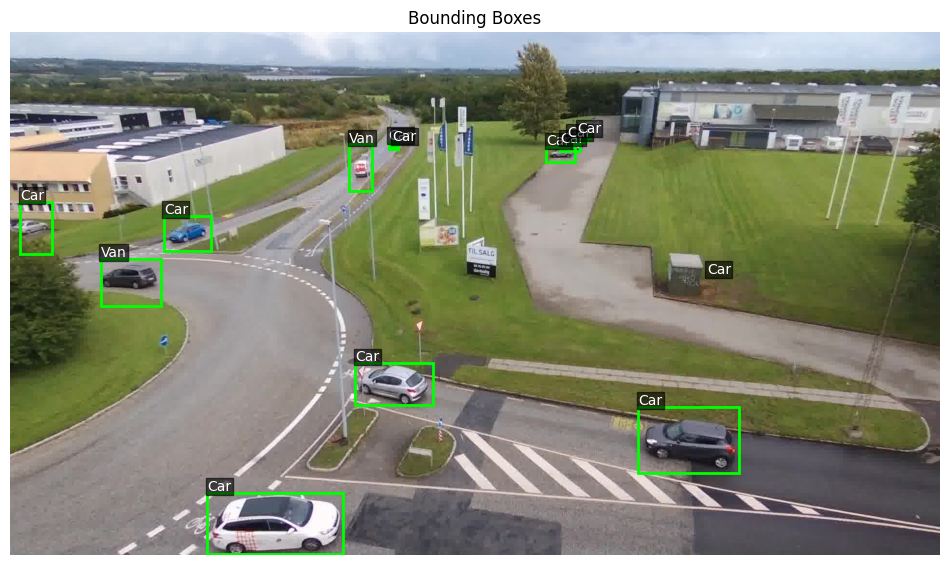

In [11]:
def visualize_raw_entry(entry, id2label=None, highlight_invalid=True):
    image = Image.open(entry["image_path"]).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for i, box in enumerate(entry["objects"]["bbox"]):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        label = (
            id2label[entry["objects"]["category"][i]]
            if id2label else str(entry["objects"]["category"][i])
        )

        is_valid = (x_max > x_min) and (y_max > y_min)

        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2,
            edgecolor='lime' if is_valid else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(
            x_min, y_min - 5, label,
            color="white", fontsize=10,
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    ax.set_title("Bounding Boxes" if highlight_invalid else "Bounding Boxes")
    plt.axis("off")
    plt.show()

entry_23057 = next(e for e in dataset["train"] if e["image_id"] == 23057)
visualize_raw_entry(entry_23057, id2label=id2label)

Before applying our filtering function to discard invalid bounding boxes, we performed a manual visual inspection of selected samples flagged as problematic. This step was essential to verify that the automatic detection of invalid annotations correctly identified entries that are indeed unusable during model training.

In [12]:
def filter_invalid_bboxes(entry):
    """
    Removes bounding boxes that have invalid geometry.
    Specifically, boxes where x_max <= x_min or y_max <= y_min are considered invalid.
    """
    valid_bbox = []
    valid_cat = []
    valid_area = []
    valid_ids = []

    for i, box in enumerate(entry["objects"]["bbox"]):
        try:
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_bbox.append(box)
                valid_cat.append(entry["objects"]["category"][i])
                valid_area.append(entry["objects"]["area"][i])
                valid_ids.append(entry["objects"]["bbox_id"][i])
            else:
                print(
                    f"[WARNING] Invalid box skipped: {box} in image {entry['image_id']} "
                    f"→ Area might be zero or negative."
                )
        except Exception as e:
            print(f"[ERROR] Could not process bbox {box} in image {entry['image_id']}: {e}")
            continue

    entry["objects"]["bbox"] = valid_bbox
    entry["objects"]["category"] = valid_cat
    entry["objects"]["area"] = valid_area
    entry["objects"]["bbox_id"] = valid_ids

    return entry

In [13]:
train_data = train_data.map(filter_invalid_bboxes)
val_data = val_data.map(filter_invalid_bboxes)
test_data = test_data.map(filter_invalid_bboxes)

Map:   0%|          | 0/21006 [00:00<?, ? examples/s]

[WARNING] Invalid box skipped: [1438, 503, 1438, 503] in image 23057 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1329, 557, 1329, 557] in image 22689 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1666, 441, 1666, 441] in image 28654 → Area might be zero or negative.
[WARNING] Invalid box skipped: [802, 98, 802, 102] in image 15453 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1640, 347, 1640, 347] in image 13389 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1441, 850, 1441, 850] in image 28802 → Area might be zero or negative.
[WARNING] Invalid box skipped: [677, 398, 677, 398] in image 8705 → Area might be zero or negative.
[WARNING] Invalid box skipped: [680, 389, 680, 389] in image 8705 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1327, 793, 1327, 793] in image 24218 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1485, 562, 1485, 562] in image 22732 → Area might 

Map:   0%|          | 0/5252 [00:00<?, ? examples/s]

[WARNING] Invalid box skipped: [653, 485, 653, 485] in image 25366 → Area might be zero or negative.
[WARNING] Invalid box skipped: [585, 0, 585, 0] in image 23913 → Area might be zero or negative.
[WARNING] Invalid box skipped: [0, 1080, 0, 1080] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [78, 288, 78, 288] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [128, 280, 128, 280] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1061, 925, 1061, 925] in image 26324 → Area might be zero or negative.
[WARNING] Invalid box skipped: [886, 766, 886, 766] in image 25011 → Area might be zero or negative.


Map:   0%|          | 0/6565 [00:00<?, ? examples/s]

[WARNING] Invalid box skipped: [1205, 1080, 1205, 1080] in image 10608 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1495, 1080, 1495, 1080] in image 10608 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1685, 382, 1685, 382] in image 10608 → Area might be zero or negative.
[WARNING] Invalid box skipped: [85, 215, 85, 215] in image 25614 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1781, 1003, 1781, 1003] in image 22694 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1892, 0, 1892, 0] in image 46 → Area might be zero or negative.
[WARNING] Invalid box skipped: [874, 689, 874, 689] in image 46 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1920, 1080, 1920, 1080] in image 27673 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1102, 662, 1102, 662] in image 27673 → Area might be zero or negative.
[WARNING] Invalid box skipped: [943, 188, 943, 188] in image 27673 → Area might b

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_26487/3916165390.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


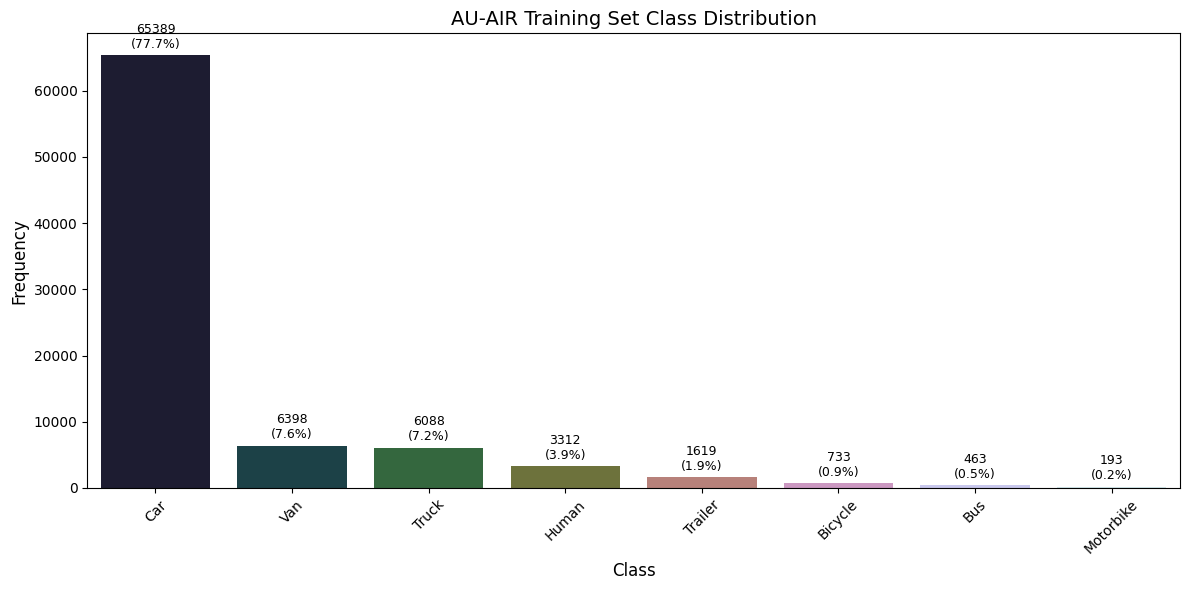

In [14]:
# Count occurrences
all_labels = []
for example in train_data:
    all_labels.extend(example['objects']['category'])

label_counts = Counter(all_labels)
total = sum(label_counts.values())

# Map to category names and prepare dataframe
class_data = [
    {
        "label": id2label[class_id],
        "count": count,
        "percent": (count / total) * 100
    }
    for class_id, count in label_counts.items()
]

class_data = sorted(class_data, key=lambda x: x["count"], reverse=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=[entry["label"] for entry in class_data],
    y=[entry["count"] for entry in class_data],
    palette="cubehelix"
)

# Add value labels
for i, entry in enumerate(class_data):
    ax.text(
        i, entry["count"] + max(label_counts.values()) * 0.01,
        f'{entry["count"]}\n({entry["percent"]:.1f}%)',
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.title("AU-AIR Training Set Class Distribution", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
#pip install albumentations

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.MotionBlur(p=0.2),
    A.Resize(800, 800),
],
bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
# Initialize processor (standard DETR processor)
checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [18]:
class AUAirDETRDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, processor, transform=None):
        self.data_list = data_list  # list of dicts, not HuggingFace dataset
        self.processor = processor
        self.transform = transform

    def __getitem__(self, idx):
        entry = self.data_list[idx]  # ⚠️ Expecting a single index

        image = np.array(Image.open(entry["image_path"]).convert("RGB"))

        bboxes = []
        category_ids = []
        for box, label in zip(entry["objects"]["bbox"], entry["objects"]["category"]):
            x_min, y_min, x_max, y_max = box
            bboxes.append([x_min, y_min, x_max, y_max])
            category_ids.append(label)

        # Apply albumentations transform if provided
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            category_ids = transformed["category_ids"]

        # Convert bbox to DETR format [x, y, width, height]
        annotations = [
            {
                "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                "category_id": cat_id,
                "area": (x_max - x_min) * (y_max - y_min),
                "iscrowd": 0
            }
            for (x_min, y_min, x_max, y_max), cat_id in zip(bboxes, category_ids)
        ]

        # Use processor
        encoding = self.processor(
            images=image,
            annotations={"image_id": entry["image_id"], "annotations": annotations},
            return_tensors="pt"
        )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": encoding["labels"][0]
        }

    def __len__(self):
        return len(self.data_list)

In [19]:
train_list = train_data.to_list()
val_list = val_data.to_list()
test_list = test_data.to_list()

train_dataset = AUAirDETRDataset(train_list, image_processor, transform=transform)
val_dataset = AUAirDETRDataset(val_list, image_processor)
test_dataset = AUAirDETRDataset(test_list, image_processor)

print("Train Dataset Type:", type(train_dataset))

Train Dataset Type: <class '__main__.AUAirDETRDataset'>


/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_26487/3440753982.py:39: UserWarning: Glyph 127878 (\N{FIREWORKS}) missing from current font.
  plt.tight_layout()
/Users/esrasekerci/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127878 (\N{FIREWORKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


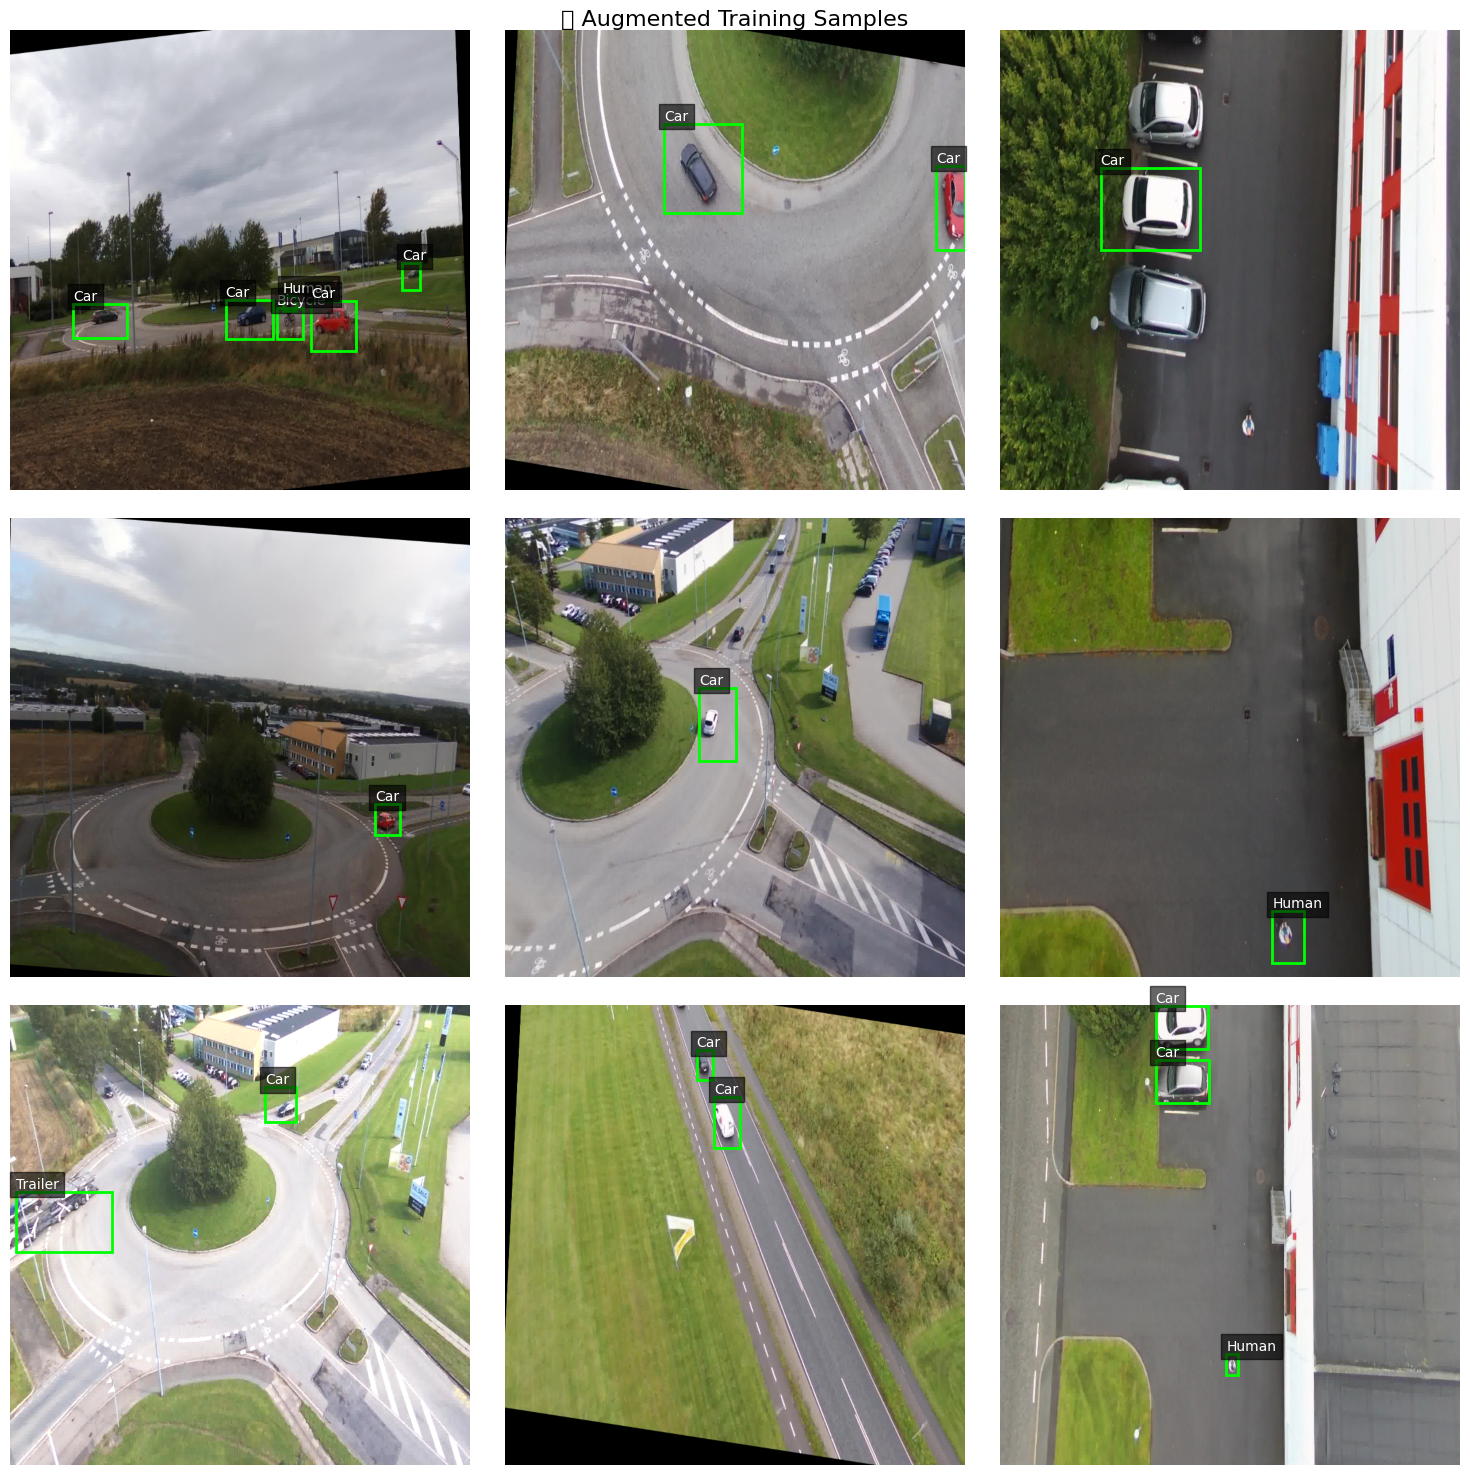

In [20]:
def visualize_augmented_examples(dataset, indices, id2label, cols=3):
    rows = (len(indices) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()

    for ax, idx in zip(axs, indices):
        entry = dataset.data_list[idx]
        image = np.array(Image.open(entry["image_path"]).convert("RGB"))

        bboxes = []
        labels = []
        for box, label in zip(entry["objects"]["bbox"], entry["objects"]["category"]):
            x_min, y_min, x_max, y_max = box
            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        # Apply the transform manually to visualize
        transformed = dataset.transform(image=image, bboxes=bboxes, category_ids=labels)
        aug_image = transformed["image"]
        aug_bboxes = transformed["bboxes"]
        aug_labels = transformed["category_ids"]

        ax.imshow(aug_image)
        for bbox, label in zip(aug_bboxes, aug_labels):
            x_min, y_min, x_max, y_max = bbox
            width, height = x_max - x_min, y_max - y_min
            ax.add_patch(patches.Rectangle((x_min, y_min), width, height,
                                           edgecolor='lime', facecolor='none', linewidth=2))
            ax.text(x_min, y_min - 5, id2label[label],
                    bbox=dict(facecolor="black", alpha=0.6), color="white", fontsize=10)

        ax.axis("off")

    # Hide extra axes
    for j in range(len(indices), len(axs)):
        axs[j].axis("off")

    plt.suptitle("🎆 Augmented Training Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_augmented_examples(train_dataset, indices=range(9), id2label=id2label)

In [21]:
from transformers import AutoModelForObjectDetection

# Define label mapping (already defined earlier in your code)
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to("cuda" if torch.cuda.is_available() else "cpu")

# Freeze EVERYTHING
for param in model.parameters():
    param.requires_grad = False

# Unfreeze ONLY prediction heads
for param in model.class_labels_classifier.parameters():
    param.requires_grad = True

for param in model.bbox_predictor.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

In [22]:
sample = train_dataset[0]
print(sample.keys())  # should be dict_keys(['pixel_values', 'labels'])

dict_keys(['pixel_values', 'labels'])


In [23]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import wandb

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

def detr_collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = [item["labels"] for item in batch]  # keep as list of dicts
    return {"pixel_values": pixel_values, "labels": labels}

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=detr_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=detr_collate_fn)

# Init W&B
wandb.init(project="detr-auair", name="custom-training-loop")

# Training loop
epochs = 2
model.to(device)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

# Save model
torch.save(model.state_dict(), "detr_auair_finetuned.pth")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Epoch 1:   0%|          | 0/5252 [00:00<?, ?it/s]

KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.
